# Machine learning error correction codes
> Sweeping conceptual difficulties under the rug with a black-box approach 
- toc: true 
- badges: true
- comments: true
- categories: [QML, QEC]
- image: images/black_box.png

In [1]:
#collapse

from collections import namedtuple
from functools import reduce
from mynimize import *
from jax.scipy.linalg import                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                expm
from jax import random
from scipy.stats import unitary_group

# Introduction

Quantum error correction codes (QECC) are crucial to the prospects of the quantum technology as well as extremely interesting from a theoretical point of view. Despite similarities to the classical error correction, there are fundamental distinctions, too. A naive attempt to generalize classical codes to work with quantum bits faces several conceptual challenges, such as no-cloning theorem and decoherence induced by a measurement. I got curious how far one can go in constructing a simple quantum ECC without worrying too much about those, using a simple machine learning model with little to no physics assumptions underneath. I think the experiment worked out pretty well, for instance, I'll show how to get a 5 qubit code. Sure, most things appear to be obvious in retrospect, and rediscovering something that you know is possible is a completely different thing. Still, I found this to be a very interesting exercise with some bonus take-aways, such as:

- Measurements are not a necessary part of the error correction. Decoding can be a unitary operation (at least for some codes).
- ?
- You can train the model on unitary errors only, general single-qubit error channels will be accounted for for free.

# Classical repetition code

Following 99% of error correction tutorials I will start with the classical repetition code. And you know what, I do not even feel guilty, this is a great time-tested warm up. So, we are sending a classical bit along a noisy channel and it is flipped with a probability $p$. The error probability can be suppressed if we are willing to send more bits. Namely, instead of sending `0` we send `000`, instead of `1` we send `111`. This is called _encoding_, we encoded a single _logical_ bit into several _physical_ bits. Due to errors, the message `000` can be corrupted in several ways:
1. `000` : no corruption, with probability $(1-p)^3$
2. `100`, `010`, `001`: single corrupted bit, with probability $3 p(1-p)^2$
3. `110`, `011`, `101`: two corrupted bits, with probability $3 p^2(1-p)$
4. `111`: all bits flipped, with probability $p^3$

Same holds for the `111` message.

Now, if the receiver sees any message except `000` or `111` he knows there was an error somewhere. He can try to fix the error by taking a majority vote, e.g. he assumes that `100` means `0` while `101` means `1`. If the single-bit errors are much more likely than two-bit or three-bit errors, this _decoding_ strategy works. More precisely, it succeeds in cases (1) and (2) but fails in cases (3) and (4). The overall success probability is therefore $(1-p)^3+3p(1-p)^2$ and for $p>1/2$ it is in fact greater than $1-p$, the success probability of the unencoded message.

# Conceptual difficulties with QECC

Now instead of sending a classical bit we want to send a qubit, also subject to noise. Can we use a similar strategy to protect the quantum bit? Textbooks often mention several apparent problems that make the quantum case sufficiently different from the classical.

1. Qubit states are continuous. Instead of sending just `0` or `1` we need to be able to send an arbitrary superposition $|\psi\rangle=\alpha|0\rangle+\beta|1\rangle$.
2. As a consequence, errors are also continuous. For example, instead of a full bit flip $X$ we can have 'just a bit' of a bit flip $R_X(\theta)=\cos(\theta/2)-i X \sin(\theta/2)$ with very small $\theta$. There are also additional error types with no classical counterparts, such as the phase flip error $Z$. General single-qubit unitary error is a linear combination $U=\alpha_0+\alpha_1 X+\alpha_2 Y+\alpha_3 Z$.
3. Quantum states can not be cloned. This means that for an unknown quantum state $|\psi\rangle$ we can not construct and transmit e.g. $|\psi\rangle\otimes|\psi\rangle\otimes|\psi\rangle$ as a plain generalization of the repetition code, although that would definitely help. 
4. When the message is received, we need to look at it to decide if there was an error and choose a correction. But looking at the quantum states can break the coherence that we were looking to preserve.

We now know that all these issues can be elegantly resolved and the modern theory of error correction is rich and beautiful. My personal agenda for this small project was to see how far can one go with a black-box approach, sweeping all conceptual problems under the rug. The main two assumptions are
- We need to use several physical qubits to safeguard a single logical qubit.
- We only try to protect against single-qubit errors.

<img src="myimages/ecc_training/black_box.png" alt="Drawing" style="width: 600px;"/>

# Machine learning QECC

Here is an architecture that I have in mind.

<img src="myimages/ecc_training/arch.svg" alt="Drawing" style="width: 1200px;"/>

First, we embed a logical qubit into $n$ physical ones. I will do this in the simplest possible way $|\psi\rangle \to |\psi\rangle\otimes |0\rangle^{n-1}$, i.e. assuming that the first physical qubit is the logical state to be transmitted while other physical qubits are initialized in $|0\rangle$ states. The initial embedding is in fact irrelevant, because after that I allow for an arbitrary encoding transformation $U_{encoding}$. It is only required to be unitary. The encoding stage does the heavy lifting, and the encoding unitary is the main variable to be optimized. After that we add an error layer, which can consist of arbitrary single-qubit unitary errors. Then goes the decoding layer, which we will trust to recover the information about the logical qubit (it will also  be trained). I will assume that the decoding layer is also a unitary. At the final step, the physical qubit state must somehow be projected onto the single-qubit state which will be our final, received and corrected state.


If you are familiar with quantum error correction, the assumption that decoding is a unitary operation and hence makes no explicit reference to syndrome measurements and things of that sort may look suspicious. We'll see that it works, and make some comments afterwards.

# Design choices

## Projecting the final state

There are still details to be filled in. One is to specify how to get a single-qubit logical state from the final state of the physical qubits. Similarly to the embedding step, I will assume that the relevant information is contained exclusively in the first physical qubit. Then, successful error correction implies that the first physical qubit is unentangled with the others after the decoding step and has the same state it had before the encoding. 

$$|\psi\rangle\otimes |0\rangle^{n-1} \to \text{Encoding+Error+Decoding} \to |\psi\rangle\otimes |e\rangle_{n-1}$$

Note that the rest of the physical qubits will end up in different states $|e\rangle_{n-1}$ depending on the error that have been corrected. Requiring that the final state is $|\psi\rangle\otimes |0\rangle^{n-1}$ regardless of the error is too strong and can not be satisfied for any interesting set of errors.

## Dealing with continuum

Next, how do we deal with the continuum of states and errors? I guess that a truly black-box approach would be to generate a large set of initial states and single-qubit errors and train the model using all this data. If successful, check on the test data to exclude overfitting. I'm sure that would work, but here I will take a shortcut and exploit the linearity of the whole construction. Denote by $U(E)$ the full unitary of the encoding+error+correction process, for some error $E$

$$U(E)=U_{decoding}\,\, U_{error}(E) \,\, U_{encoding} \ .$$

For a given initial state $|\psi\rangle=\alpha |0\rangle+\beta |1\rangle$ and a fixed error $E$, the final state can be reconstructed from the action on $|0\rangle$ and $|1\rangle$ states

$$|\psi\rangle\otimes |0\rangle^{n-1}=\alpha\,\, U(E) |0\rangle\otimes|0\rangle^{n-1}+\beta\,\, U(E)|1\rangle\otimes|0\rangle^{n-1} \ .$$

Similarly, if we can correct errors corresponding to $X, Y$ and $Z$ unitaries on a given qubit, we will be able to correct an arbitrary linear combination of them, which is unitary. Indeed, say we can correct both $X$ and $Y$ errors
\begin{align*}
|\psi\rangle\otimes |0\rangle^{n-1}\to U(X) \to |\psi\rangle\otimes |x\rangle_{n-1} \ ,\\
|\psi\rangle\otimes |0\rangle^{n-1}\to U(Y) \to |\psi\rangle\otimes |y\rangle_{n-1} \ .
\end{align*}
Then their unitary linear combination will also be corrected in a sence that the state of the first physical qubit is the original encoded state
\begin{align*}
|\psi\rangle\otimes |0\rangle^{n-1}\to U(aX+bY) \to |\psi\rangle\otimes\left(a|x\rangle_{n-1}+b|y\rangle_{n-1}\right) \ .
\end{align*}
In fact, correcting $X,Y$ and $Z$ errors on any of the qubits is sufficient to correct their arbitrary linear combination, including non-unitary ones and those acting on different qubits. More on that later.

# Implementation

Here is a code that implements the model. I do no use any quantum framework and deal with unitary matrices directly. That requires making a few tensor products here and there, but nothing cumbersome. I include the code right below in order to make this notebook/post self-contained, but do not go into detailed explanations. Here are several technical highlights though.
- I use [JAX](https://jax.readthedocs.io/en/latest/#) as a numerical optimization backend. This why all the `jnp`s instead of `np`s.
- I take a very low-key approach to optimization over unitary matrices, parametrizing them by Hermitian matrices $U=e^{i H}$. Basis in Hermitian matrices can be chosen to consist of $e_{ii}, e_{ij}+e_{ji}$ and $i(e_{ij}-e_{ji})$, where $e_{ij}$ is a matrix with all elements zero except one at position $ij$. Matrix exponentiation is an expensive procedure and to scale the code to more qubits a better parametrization of the unitary group is required, e.g. as done here [QGOPT](https://github.com/LuchnikovI/QGOpt).
- I choose the loss associated with an error correction process $U(E)$ in the following way. Let $|\Psi_0\rangle$ be the image of $|0\rangle$ and $|\Psi_1\rangle$ of $|1\rangle$
$$|\Psi_0\rangle=U(E)|0\rangle\otimes |0\rangle^{n-1},\quad |\Psi_1\rangle=U(E)|1\rangle\otimes |0\rangle^{n-1}\ \ . $$
The loss is
$$L(E) = 2-L_Z-L_X, \qquad L_Z=\langle \Psi_0|Z_1|\Psi_0\rangle, \qquad L_X=\operatorname{Re} \langle \Psi_0|X_1|\Psi_1\rangle \ .$$
The term $L_Z$ is maximal $L_Z=1$ when $|\Psi_0\rangle=|0\rangle \otimes |e\rangle_{n}$, i.e. when the $|0\rangle$ state of the first physical qubit is preserved by the error correction. If $|0\rangle$ is mapped to a mixed state or to a pure state different from $|0\rangle$ we have $L_Z<1$. The term $L_X$ is maximal when the $|\Psi_1\rangle=X_1 |\Psi_0\rangle$. If $|0\rangle\otimes|0\rangle^{n-1}\to|0\rangle \otimes |e\rangle_{n}$, this  condition implies that $|1\rangle\otimes|0\rangle^{n-1} \to |1\rangle \otimes |e\rangle_{n}$. By linearity,  this is sufficient for an arbitray input state to be corrected when subject to this error.
- The total loss is the sum of individual losses over all $X, Y, Z$ errors acting on each qubit
$$L(E)=\sum_{i=1}^{n}\left(L(X_i)+L(Y_i)+L(Z_i)\right) \ .$$
However, we may wish to correct only a subset of errors, say only $X$ errors. Then include only those in the loss function.

In [2]:

# Pauli matrices.
x_mat = jnp.array([[0, 1],
                   [1, 0]])

y_mat = jnp.array([[0, -1j],
                   [1j, 0]], dtype=jnp.complex64)

z_mat = jnp.array([[1, 0],
                   [0, -1]])

pauli = (jnp.identity(2), x_mat, y_mat, z_mat)


# Parametrized unitary matrices.
class UnitaryLayer:
    def __init__(self, num_qubits):
        self.num_qubits = num_qubits
        self.num_params = 4**num_qubits
    
    @staticmethod
    def hermitian_basis(num_qubits):
        d = 2**num_qubits
        diag_basis = [jnp.zeros((d, d), dtype=jnp.complex64).at[i, i].set(1) for i in range(d)]
        off_diag_real_basis = [jnp.zeros((d, d), dtype=jnp.complex64).at[i, j].set(1).at[j, i].set(1) for i in range(d) for j in range(i)]
        off_diag_im_basis = [jnp.zeros((d, d), dtype=jnp.complex64).at[i, j].set(1j).at[j, i].set(-1j) for i in range(d) for j in range(i)]
        return jnp.array(diag_basis+off_diag_real_basis+off_diag_im_basis)
    
    def unitary(self, params):
        generator = jnp.tensordot(self.hermitian_basis(self.num_qubits), params, axes=((0, ), (0, )))
        return expm(1j*generator)
    

# Matrices corresponding individual single-qubit errors.    
class ErrorLayer:
    def __init__(self, num_qubits, errors=pauli):
        self.num_qubits = num_qubits
        self.errors = errors
    
    def unitary(self, q, e):
        error_list = [self.errors[e] if i==q else jnp.identity(2) for i in range(self.num_qubits)]
        return reduce(jnp.kron, error_list)
        
    def all_error_unitaries(self):
        single_error_unitaries = [self.unitary(q, e) for q in range(self.num_qubits) for e in range(len(self.errors))]
        id_error = jnp.identity(2**self.num_qubits)
        return jnp.array([id_error]+single_error_unitaries)

# Model parameters as a namedtuple.    
ecc_params = namedtuple('ECCparams', ['encoding_params', 'decoding_params'])

class ECCmodel:
    def __init__(self, num_qubits, error_layer, params=None):
        self.num_qubits = num_qubits
        self.error_layer = error_layer
        self.encoding_layer = UnitaryLayer(num_qubits)
        self.decoding_layer = UnitaryLayer(num_qubits)
        self.params = params
    
    @staticmethod
    def embed(initial_state, num_qubits):
        """Take |psi> and output |psi>|0,0,0, ...> """
        return jnp.kron(initial_state, jnp.zeros(2**(num_qubits-1)).at[0].set(1))
    
    
    def final_state(self, initial_state, encoding_unitary, decoding_unitary, error_unitary):
        s = decoding_unitary @ error_unitary @ encoding_unitary @ initial_state
        return s
    
    def loss(self, params, error_unitary):
        encoding_unitary = self.encoding_layer.unitary(params.encoding_params)
        decoding_unitary = self.decoding_layer.unitary(params.decoding_params)
        
        final_states = []
        for initial_state_1q in [[1,0], [0,1]]:
            initial_state = self.embed(jnp.array(initial_state_1q, dtype=jnp.complex64), self.num_qubits)
            final_state = self.final_state(initial_state, encoding_unitary, decoding_unitary, error_unitary)            
            final_states.append(final_state)
        
        Psi_0, Psi_1 = final_states
        
        X1 = reduce(jnp.kron, [x_mat]+[jnp.identity(2)]*(self.num_qubits-1))
        Z1 = reduce(jnp.kron, [z_mat]+[jnp.identity(2)]*(self.num_qubits-1))
        
        Z_avg = jnp.real(Psi_0.conj() @ Z1 @ Psi_0).sum()
        X_off_diag = (Psi_0.conj() @ X1 @ Psi_1).sum()
        return 2-Z_avg-jnp.real(X_off_diag)
    
    
    def train(self, opt_options=OptOptions(num_iterations=1000)):

        error_unitaries = self.error_layer.all_error_unitaries()
        
        def loss(params):
            losses = vmap(lambda error_u: self.loss(params, error_u))(error_unitaries)
            
            return losses.sum()/len(error_unitaries)
        
        initial_params = random.uniform(random.PRNGKey(opt_options.random_seed), shape=(2, self.encoding_layer.num_params))
        initial_params = [ecc_params(initial_params[0], initial_params[1])]
        
        # `mynimize` is just my custom optimization routine with a JAX backend. 
        results = mynimize(loss, initial_params, opt_options)        
        self.params = results.best_result.best_params
        return results.best_result

# Quantum repetition code

Now let us put the model to use. It is well known that with three physical qubits one can protect a logical qubit from $X$ erorrs. This is a generalization of the classical repetition code. Let's see if our model can do that.

CPU times: user 14.9 s, sys: 58.4 ms, total: 15 s
Wall time: 15 s


Text(0.5, 1.0, 'Loss history')

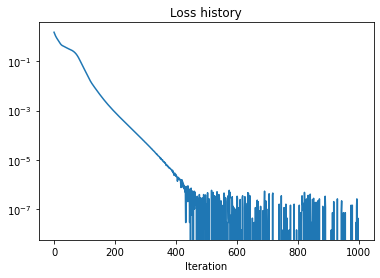

In [3]:
%%time

num_qubits = 3
error_layer = ErrorLayer(num_qubits, errors=[x_mat])

model = ECCmodel(num_qubits, error_layer)
result = model.train(OptOptions(num_iterations=1000))

result.plot_loss_history();
plt.xlabel('Iteration');
plt.title('Loss history');

OK, the optimization is clearly successfull. Of course there is always a chance that there are mistakes in the code or in the definition of the loss function itself. I will give a more thorough verification for the 5-qubit code later. By modifying and re-running the cell above you can also do some simple sanity checks -- see if the same results can be achieved with fewer qubits (`num_qubits`$\to$2) or if more errors can be corrected (`errors`$\to$`[x_mat, y_mat]`). Neither works, of course.

# Standard description of the quantum repetition code

Now that we have seen that a black-box approach works it is instructive to revisit the usual construction of the error correcting codes. Here is how the quantum repetition code, which is able to correct $X$ errors, works. Encoding is done as follows

$$|\psi\rangle=\alpha|0\rangle+\beta|1\rangle\to \alpha |000\rangle+\beta|111\rangle \ .$$

This does not violate the no-cloning theorem because the new state is not $|\psi\rangle\otimes|\psi\rangle\otimes|\psi\rangle$. Coefficients $\alpha$ and $\beta$, which define the state, are not copied. This encoding can be done with the following circuit 

<img src="myimages/ecc_training/ghz.png" alt="Drawing" style="width: 150px;"/>

Now say there was an $X$ error acting on the first qubit during the transmission
$$\alpha |000\rangle+\beta|111\rangle\to X_1 \to \alpha |100\rangle+\beta|011\rangle$$
Can we detect an correct it? The problem is that measuring any of the qubits individually destroys their coherent superposition. A workaround is to make collective measurements $Z_1Z_2$ and $Z_1Z_3$, known as parity checks. Both terms in the corrupted decomposition have the same eigenvalues and hence coherence is preserved. Parity checks allow to identify qubit 1 as corrupted, and correct the error by applying $X_1$. 

# Can we do without a measurment?

Measurements and post-selected correction operators were not part of our model, where the decoder is unitary. Is there something wrong with our approach, or measurements are not strictly necessary? I do think they aren't, but you would not be able to tell from most of the introductory literature. To illustrate the situation for the repetition code, I came up with the following unitary circuit, which can correct/decode any single $X$ error in the repetition code

<img src="myimages/ecc_training/dec.png" alt="Drawing" style="width: 200px;"/>

It is straightforward to check that it transforms vectors with single $X$ errors as follows.
\begin{align*}
I_{}:\quad |000\rangle\to |000\rangle,\quad |111\rangle\to |100\rangle\\
X_1:\quad|100\rangle\to |011\rangle,\quad |011\rangle\to |111\rangle\\
X_2:\quad|010\rangle\to |101\rangle,\quad |010\rangle\to |110\rangle\\
X_3:\quad|001\rangle\to |001\rangle,\quad |110\rangle\to |101\rangle\\
\end{align*}
Important things to note here are that the first qubit value becomes the majority vote, while two other qubit registers agree within the same line. I do not claim that our numerical optimization above discovered exactly this circuit and/or the repetition encoding, but it must be something equivalent.

# 5 qubit code

The smallest amount of physical qubits that can correct against arbitrary single-qubit errors is known to be 5. Let me sketch a proof. Please! No, it's not needed to make my points, I just like it a lot. OK? Great! 

If a code can correct an arbitrary single-qubit error, it can also recover from the loss of two qubits.
If we'd have an ECC with just four qubits, we could separate them into two groups 4=2+2. Each group could recover the encoded state, which produces two copies of it. This violates the no-cloning theorem! Lowering the number of qubits does not help, of course.

Good, let us try to train the model with 5 physical qubits and the error operators that span all single-qubit errors.

CPU times: user 2min 23s, sys: 826 ms, total: 2min 23s
Wall time: 2min 27s


Text(0.5, 1.0, 'Loss history')

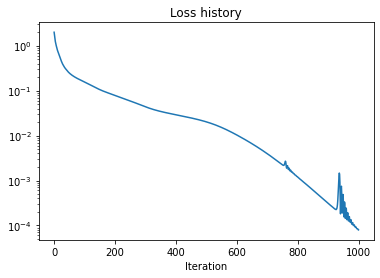

In [34]:
%%time

num_qubits = 5
error_layer = ErrorLayer(num_qubits, errors=[x_mat, y_mat, z_mat])

model = ECCmodel(num_qubits, error_layer)
result = model.train(OptOptions(num_iterations=1000))

result.plot_loss_history();
plt.xlabel('Iteration');
plt.title('Loss history');

The loss function indicates that our model learns a 5-qubit ECC. You may wish to check that it does not work with fewer qubits, e.g. `num_qubits`$\to$4. Another empirical observation is that if the model is trained on $X$ and $Z$ errors only, it will be able to correct $Y$ errors as well (passes verification below). This does not seem to be guarantied in general, as [counter-examples](https://quantumcomputing.stackexchange.com/questions/26846/if-a-quantum-error-correcting-code-corrects-both-x-and-z-errors-will-it-be) exist.

# Verification

To convince you and myself that the loss plot above does reflect learning a genuine ECC here I will carry out an independent check. First let me note that the way errors enter in the model we trained is not completely general. The most general evolution of the initial state under an interaction with an environment is described by a quantum channel

$$|\psi\rangle\to \rho = \operatorname{Tr}_{n-1}\sum {M_a}|\Psi\rangle\langle\Psi|M_a^\dagger,\qquad |\Psi\rangle=|\psi\rangle\otimes |0\rangle^{n-1} .$$

Here $\rho$ is the final density matrix of the first physical qubit, which by our assumption corresponds to the logical qubit after error correction process. The partial trace is taken with respect to the other physical qubits. Matrices $M_a$ are called Kraus operators and could be thought of as a combination
$$M_a = U_{decoding} E_a U_{encoding} \ .$$
We trained our model on cases where the error part $E_a$ in each Kraus operator $M_a$ is a single Pauli operator acting on some qubit, e.g. $E_a=X_2$. A general single-qubit error corresponds to each $E_a$ being a linear combination of single-qubit unitaries
$$E_a=\sum_{i=1}^{n} c_{ai} U_i.$$
For example, one of them could be something like $E_1 = c_{11}(0.13 X_1+2.7 Y_1)+c_{12} Z_2 + c_{13} (Y_1-0.55 Z_1)$. Kraus operators are not required to be unitary, but only to satisfy the completeness relation $\sum M_a^\dagger M_a=1$. Our model was trained so that $M_a |\Psi\rangle=|\psi\rangle \otimes |\text{some state}\rangle$ when $M_a$ only contains Pauli errors acting on a single qubit. However, this equation extends to arbitrary single-qubit errors by linearity.

To perform an independent check I generate a bunch of initial states and generic single-qubit errors $E_a$. I will restrict to channels with single (non-normalized) Kraus operators for simplicity. If (normalized) density matrices
$$ \rho_a=\frac{M_a|\Psi\rangle\langle\Psi|M_a^\dagger}{\langle \Psi|M_a^\dagger M_a|\Psi\rangle} $$
reproduce the correlators of the original state for any $M_a$, they surely do for any sum over $M_a$. Thus, I will check that

$$\langle\psi|X|\psi\rangle=\operatorname{tr}\rho_a X,\quad \langle\psi|Y|\psi\rangle=\operatorname{tr}\rho_a Y,\quad \langle\psi|Z|\psi\rangle=\operatorname{tr}\rho_a Z .$$

Essentially, we'll do the full state tomography of the first physical qubit. This of course should be equivalent to the loss function we used during training, but I think reformulation is useful as an additional consistency check.

In [35]:
# Random seed, JAX-style
key, *keys = random.split(random.PRNGKey(0), 3)

# Sample sizes.
num_qubits = model.num_qubits
num_initial_states = 100
num_errors = 100

# Initial states, drawn at random and normalized.

initial_states = random.uniform(keys[0], shape=(2, num_initial_states, 2)) # 2x real components
initial_states = initial_states[0]+1j*initial_states[1] # combine into 1x complext components

def norm_state(s):
    return jnp.sqrt(jnp.real(s.conj()*s).sum())

norms = [norm_state(s) for s in initial_states]
initial_states = [s/norm_state(s) for s in initial_states]

### Defining random linear combinations of single-qubits errors is a bit cumbersome, but purely technical.

# Random single-qubit errors.
random_1q_unitaries = unitary_group.rvs(2, size=num_errors*num_qubits).reshape(num_errors, num_qubits, 2, 2)
random_coefficients = random.uniform(keys[1], (num_errors, num_qubits))


def error_at_position(error_u, i, num_qubits):
    """Takes U and returns tensor product 1 x 1 x ... U x 1 ... x 1 with U at position i."""
    ops = [jnp.identity(2)]*num_qubits
    ops[i] = error_u
    return reduce(jnp.kron, ops)

def make_error_operator(errors, coeffs):   
    """Takes a list of 1q errors and puts error 1 on qubit 1, error 2 on qubit 2, etc, then takes their liner combination."""
    num_qubits = len(errors)
    full_errors = [error_at_position(u, i, num_qubits) for i, u in enumerate(errors)]
    
    return sum([u*c for u, c in zip(full_errors, coeffs)])

errors = [make_error_operator(errors, coeffs) for errors, coeffs in zip(random_1q_unitaries, random_coefficients)]
errors = jnp.array(errors)

So finally we have a bunch of initial states and general (non-unitary) single-qubit error operators. Let's see directly the the model is able to correct them.

In [39]:
params = model.params

u_encoding = model.encoding_layer.unitary(params.encoding_params)
u_decoding = model.decoding_layer.unitary(params.decoding_params)

def density_matrix(s):
    """Density matrix of the first qubit."""
    num_qubits = int(jnp.log2(len(s)))
    s = s.reshape([2]*num_qubits)
    axes = list(range(1, num_qubits))
    rho = jnp.tensordot(s, s.conj(), axes=(axes, axes))
    return rho
    

def tomography_loss(initial_state, error_u):
    final_state = u_decoding @ error_u @ u_encoding @ ECCmodel.embed(initial_state, num_qubits)
    # For non-unitary errors the state should be normilized.
    final_state = final_state/jnp.sqrt(jnp.real((final_state.conj()*final_state).sum()))
    final_rho = density_matrix(final_state)

    pauli_averages_initial = [(initial_state.conj() @ p @ initial_state).sum() for p in [x_mat, y_mat, z_mat]]
    pauli_averages_final = [jnp.trace(final_rho @ p) for p in [x_mat, y_mat, z_mat]]
    
    loss = sum([(avg_i - avg_f)**2 for avg_i, avg_f in zip(pauli_averages_initial, pauli_averages_final)])

    return jnp.real(loss)


losses = [tomography_loss(s, u) for s in initial_states for u in errors]
avg_loss = sum(losses)/len(losses)
print(f'Average loss from tomography: {float(avg_loss)}')

Average loss from tomography: 0.11509232223033905


OK, the average tomographic loss is basically within the machine precision, which makes a strong case for the fact our simple model did learn a genuine ECC code on 5 qubits. This wraps up my experiment!